**Обучим Ridge регрессию**

**Для нашего кейса выбор этого алгоритма обусловлен тем,что в данных присутсвует значительное количество выбросов, а Ridge штрафует за большие веса тем самым снижая влияние выбросов**

**Кроме того, не будем дублировать анализ данных, попробуем добавить несколько признаков обработав имеющиеся и уже в отношении их проанализируем, стоит их использовать или нет**

# Загрузка данных и необходимых библиотек

In [106]:
import pandas as pd
import numpy as np
import regex as re
import math
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler # среднее 0, ст. отклонение 1
from sklearn.linear_model import Ridge, Lasso


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
RANDOM_SEED = 42

In [5]:
df = pd.read_excel("/content/drive/MyDrive/Разведочный анализ/Data/DATA.xlsx", index_col=0)
df.head(1)

name    price  ...  car_age  popularity
0  Jeep Grand Cherokee IV (WK2) Рестайлинг  4070000  ...     1435  146.058824

[1 rows x 24 columns]

# Дополнительный анализ и предобработка данных

## Обработаем колонку car_model и извлечем из нее доп признаки (поколение и рестайлинг)

Устраним неточности в данных

In [8]:
df.car_model.loc[df[df.car_brand == 'LADA'].index] = df[df.car_brand == 'LADA'].car_model.str.split(' ', 1, expand=True)[1]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [12]:
df[df.car_brand == 'LADA'].head(1)

name   price  grade  ...  log_price  car_age popularity
1  LADA (ВАЗ) 2107  129000    4.0  ...  11.767575     6183  39.571429

[1 rows x 24 columns]

In [14]:
df.car_brand.loc[df[df.car_brand == 'Land'].index] = 'Land Rover'
df[df.car_brand == 'Land Rover'].car_model.str.replace('Rover ', '')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


9                                                Range III
163                                 Range III Рестайлинг 2
165                                              Range III
240                                 Range III Рестайлинг 2
242                                              Range III
                               ...                        
22882               5.0 S/C AT SVR 2 поколение, рестайлинг
22883      4.4 SD AT Autobiography 4 поколение, рестайлинг
22884                           3.0 TD AT HSE  4 поколение
22885    5.0 S/C AT SVAutobiography Dynamic 4 поколение...
22886                 MHEV 2.0 AT R-Dynamic SE 2 поколение
Name: car_model, Length: 716, dtype: object

In [15]:
df.car_model.loc[df[df.car_brand == 'Land Rover'].index] = df[df.car_brand == 'Land Rover'].car_model.str.replace('Rover ', '')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
df[df.car_brand == 'Land Rover'].head(1)

name   price  grade  ...  log_price  car_age popularity
9  Land Rover Range Rover III  598000    6.0  ...  13.301348     6549  29.272727

[1 rows x 24 columns]

### Извлечем новые признаки

In [19]:
df['car_model_new'] = df.car_model.str.split(' ', 1, expand=True)[0]
df['car_model_type'] = df.car_model.str.split(' ', 1, expand=True)[1]
df.head(1)

name  ...                car_model_type
0  Jeep Grand Cherokee IV (WK2) Рестайлинг  ...  Cherokee IV (WK2) Рестайлинг

[1 rows x 26 columns]

Займемся колонкой car_model_type и извлечем из нее доп признаки (поколение и рестайлинг)

In [26]:
def car_type(x):
  label = {'I' : 1,
           'II' : 2,
           'III' : 3,
           'IV' : 4,
           'V' : 5,
           'VI' : 6,
           'VII' : 7,
           'VIII' : 8,
           'IX' : 9,
           'X' : 10,
           'XI' : 11,
           'XII' : 12,
           'XIII' : 13}
  result = []
  try:
    if 'поколение' in x.lower():
      tmp = x.lower().split()
      ind = tmp.index('поколение')
      result.append(int(tmp[ind - 1]))
      if 'рестайлинг' in x.lower():
        result.append('рестайлинг')
    else:
      num = re.search('([IVX]{1,4})', x).group()
      result.append(label.get(num, 0))
      if 'рестайлинг' in x.lower():
        result.append('рестайлинг')
  except:
    result.append(0)
  return result

In [30]:
# Добавим столбец с поколениями авто
df['car_gen'] = df.car_model_type.apply(lambda x: car_type(x))
df.head(1)

name  ...          car_gen
0  Jeep Grand Cherokee IV (WK2) Рестайлинг  ...  [4, рестайлинг]

[1 rows x 27 columns]

Разобьем столбец car_generation на 2 суб колонки "поколение", "рестайлинг"

In [31]:
df[['car_generation', 'restyling']] = pd.DataFrame(df.car_gen.tolist(), index=df.index)
df.head(1)

name    price  ...  car_generation   restyling
0  Jeep Grand Cherokee IV (WK2) Рестайлинг  4070000  ...               4  рестайлинг

[1 rows x 29 columns]

Уберем лишние столбцы

In [33]:
df.drop(columns=['car_model', 'car_model_type', 'car_gen'], axis=1, inplace=True)

In [156]:
df.engine_volume.fillna(0, inplace=True)

In [158]:
df.engine_volume.isnull().sum()

0

## Рассмотрим категориальные переменные

In [38]:
df.describe(include=['object'])

name    back  ... car_model_new   restyling
count             32753   32753  ...         32753        5230
unique             5622      21  ...           843           1
top     LADA (ВАЗ) 2114  missed  ...         Focus  рестайлинг
freq                186   17464  ...           668        5230

[4 rows x 12 columns]

Преобразуем колонку рестайлинг

In [39]:
df.restyling = df.restyling.apply(lambda x: 1 if (x == 'рестайлинг') else 0)

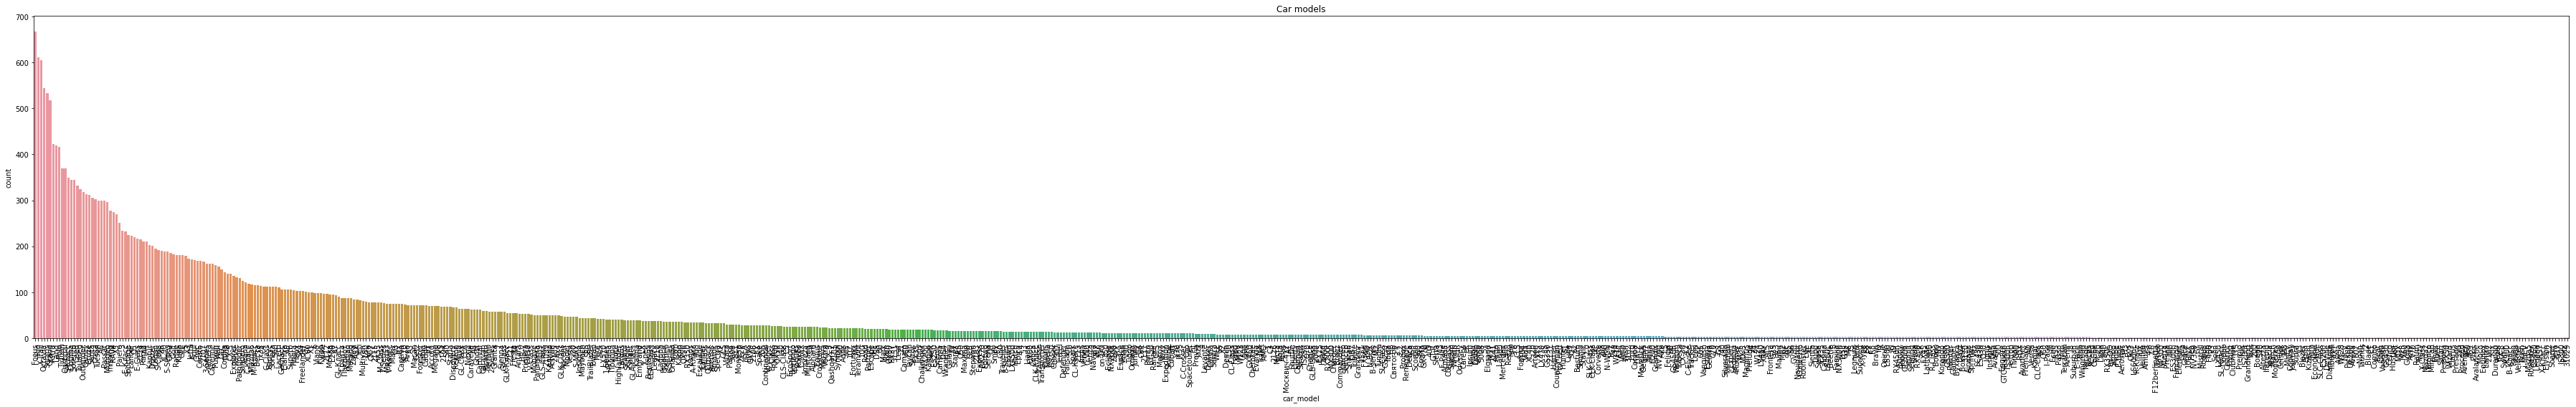

In [43]:
plt.figure(figsize=(50, 8));
sns.barplot(data=df.car_model_new.value_counts().to_frame().reset_index().rename(columns={"index": "car_model", "car_model_new": "count"}), 
            x='car_model', 
            y='count') \
            .set_title('Car models')
plt.xticks(rotation=90)
plt.tight_layout()

**В моделях авто очень длинный хвост возможно есть смысл заменить редко встречающиеся модели на общую категорию "другое"**

In [80]:
models = df.car_model_new.value_counts().to_frame().rename(columns={"index": "car_model", "car_model_new": "count"})
models.describe()

count
count  843.000000
mean    38.852906
std     80.381098
min      1.000000
25%      2.000000
50%      7.000000
75%     36.000000
max    668.000000

Не будем этого делать, используем вместо этого Lasso для зануления признаков.


Посмотрим на графики новых признаков и таргета

In [109]:
fig = px.scatter(df, x=df["car_model_new"].astype('category').cat.codes,\
                 y="log_price", trendline="ols", opacity=0.05);
fig.show()

In [110]:
fig = px.scatter(df, x="car_generation", y="log_price", trendline="ols", opacity=0.05)
fig.show()

**Эти признаки можно использовать для обучения модели**

###Преобразем столбец comment с комментариями (возмем его длину)

In [47]:
df.comment = df.comment.str.len()
df.head(1)

name    price  ...  car_generation restyling
0  Jeep Grand Cherokee IV (WK2) Рестайлинг  4070000  ...               4         1

[1 rows x 26 columns]

In [69]:
df.comment.value_counts().to_frame().rename(columns={"index": "len", "comment": "count"})

count
1.0    17533
77.0    2179
13.0     743
44.0     705
36.0     354
...      ...
171.0      1
606.0      1
940.0      1
382.0      1
917.0      1

[717 rows x 1 columns]

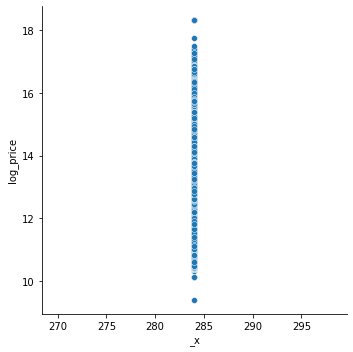

In [73]:
sns.relplot(data=df, x=df.comment.quantile(0.9), y='log_price')

**Вывод: этот признак не годится**

###Разберемся с количеством владельцев

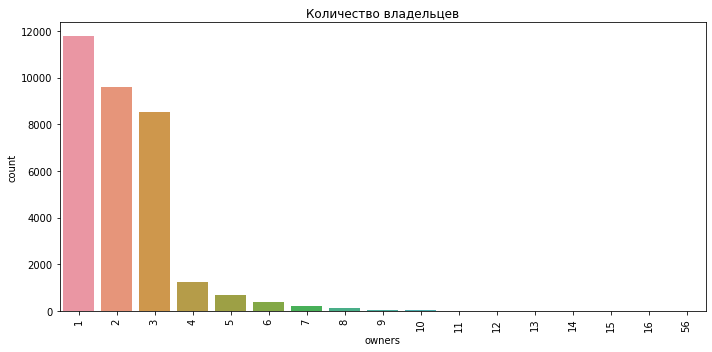

In [116]:
plt.figure(figsize=(10, 5));
sns.barplot(data=df.owners.value_counts().to_frame().reset_index().rename(columns={"index": "owners", "owners": "count"}), 
            x='owners', 
            y='count') \
            .set_title('Количество владельцев')
plt.xticks(rotation=90)
plt.tight_layout()

Объединим все объявления в которых больше 4 владельцев в категорию 4

In [123]:
df.owners = df.owners.apply(lambda x: x if x < 4 else 4)

### Разберемся с типом кузова

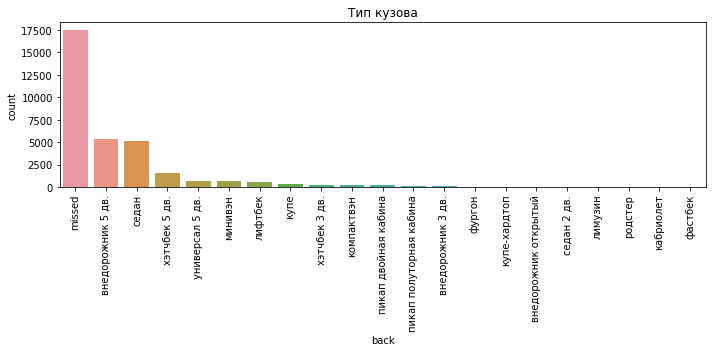

In [128]:
plt.figure(figsize=(10, 5));
sns.barplot(data=df.back.value_counts().to_frame().reset_index().rename(columns={"index": "back", "back": "count"}), 
            x='back', 
            y='count') \
            .set_title('Тип кузова')
plt.xticks(rotation=90)
plt.tight_layout()

Объединим все признаки которых встречается меньше 9 раз

In [135]:
back_low_count = df.back.value_counts()[df.back.value_counts() <= 9].index.to_list()

In [139]:
df.back = df.back.apply(lambda x: x if x not in back_low_count else 'missed')

Немного уменьшили хвост для back

**Вывод:**

**Учитывая проведенный анализ для обучения модели возьмем следующие категориальные признаки:**

1) back  
2) transmission  
3) drive  
4) rudder  
5) owners  
6) engine_type  
7) car_brand  
8) car_model_new  
9)	car_generation  
10)	restyling  

# Рассмотрим числовые признаки

Исчерпывающий анализ числовых признаков уже проведен, поэтому единственное что стоит добавить это логарифм от нелинейных признаков

## Рассмотрим колонку horsepower (лошадиные силы)

In [141]:
fig = px.scatter(df, x='horsepower', y="log_price", trendline="ols", opacity=0.05);
fig.show()

Так как зависимость нелинейная возьмем логарифм

In [142]:
df['horsepower_log'] = np.log1p(df.horsepower)

In [143]:
fig = px.scatter(df, x='horsepower_log', y="log_price", trendline="ols", opacity=0.05);
fig.show()

**Вывод:**
Этот признак можно использовать в нашей линейной модели

Посмотрим еще на один признак - налог, он считается от лошадиных сил и коррелирует с ними

In [146]:
df[['tax', 'horsepower']].corr(method='pearson')

tax  horsepower
tax         1.00000     0.87659
horsepower  0.87659     1.00000

Налог не будем использовать в нашей модели, из-за зависимости от другого признака

In [147]:
df.head(1)

name    price  ...  restyling horsepower_log
0  Jeep Grand Cherokee IV (WK2) Рестайлинг  4070000  ...          1       5.497168

[1 rows x 27 columns]

**Вывод:**

**Учитывая проведенный анализ для обучения модели возьмем следующие числовые признаки:**

1) run  
2) engine_volume  
3) horsepower_log  
4) car_age  


## Соберем данные в общую таблицу

In [159]:
DATA = pd.concat([
        df.run,
        df.engine_volume,
        df.horsepower_log,
        df.car_age,
        df.back,
        df.transmission,
        df.drive,
        df.rudder,
        df.owners,
        df.engine_type,
        df.car_brand,
        df.car_model_new,
        df.car_generation,
        df.restyling, 
        df.log_price,
        df.price], axis=1)

DATA.head(2)

run  engine_volume  horsepower_log  ...  restyling  log_price    price
0  56500            3.0        5.497168  ...          1  15.219154  4070000
1  77000            1.6        4.317488  ...          0  11.767575   129000

[2 rows x 16 columns]

# **Обучение модели**

**Отделим таргет от признаков**

In [162]:
X, y = DATA.iloc[:, :-2], DATA.iloc[:,-2]

**Преобразуем категориальные переменные с помощью OHE**

In [164]:
X.head(1)

run  engine_volume  ...  car_generation  restyling
0  56500            3.0  ...               4          1

[1 rows x 14 columns]

In [165]:
ohe = ColumnTransformer([('One Hot', OneHotEncoder(sparse=False), [4, 5, 6, 7, 8, 9, 10, 11, 12])], remainder='passthrough')
oh = ohe.fit(X)
X_ohe = oh.transform(X)

**Разобьем выборку на train и test**

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.4, random_state=RANDOM_SEED)

In [170]:
X_train.shape

(19651, 975)

In [171]:
X_test.shape

(13102, 975)

**Отмасштабируем выборку**

In [172]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)

## **Обучил LASSO регрессию для отбора признаков с нулевыми весами (произведем L1 регуляризацию)**

**Подберем гиперпараметры**

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

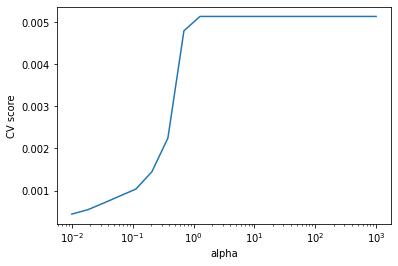

In [173]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_mean_squared_log_error", cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [176]:
lasso = Lasso(alpha=0.01).fit(X_train, y_train)

Посмотрим на метрики (RMSLE, R2)

In [177]:
mean_squared_log_error(y_test, lasso.predict(X_test), squared=False)

0.02091361086557745

In [178]:
r2_score(y_test, lasso.predict(X_test))

0.9186873941503453

**Посмотрим какие признаки занулились**

In [179]:
cf = lasso.coef_

In [180]:
drop = []
for i in range(len(cf)):
  if cf[i] == 0:
    drop.append(i)

**Количество признаков равных 0:**

In [181]:
len(drop)

805

Удалим их

In [184]:
X_train2 = np.delete(X_train, drop, axis=1)
X_test2 = np.delete(X_test, drop, axis=1)

In [183]:
X_train2.shape

(19651, 170)

In [185]:
X_test2.shape

(13102, 170)

# **Теперь обучим Ridge регрессию**

**Подберем оптимальные гиперпараметры**

Best alpha = 545.5595


Text(0, 0.5, 'CV score')

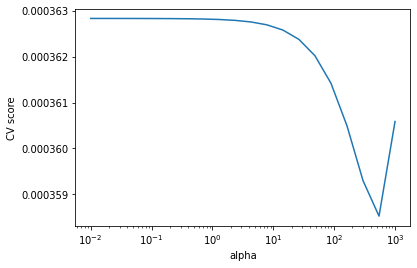

In [186]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_mean_squared_log_error", cv=10)
searcher.fit(X_train2, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [187]:
# Обучим Ridge Регрессию
ridge = Ridge(alpha=545.5595).fit(X_train2, y_train)

In [192]:
# RMSLE
mean_squared_log_error(y_test, ridge.predict(X_test2), squared=False)

0.01950090191283011

In [194]:
# R2
r2_score(y_test, ridge.predict(X_test2))

0.9286881819245244

**Выводы:**

**Наилучшее значение равно для RMSLE равно 0,0. Мы получили 0.0195**

**Кроме того, мы дополнительно посчитали коэффициент детерминации $R^2$ (наилучшая возможная оценка равна 1,0) и получили 0.9287**

# **Построим графики и посмотрим на полученный результат**

Попробуем оценить качество нашей модели визуально.

Построим распределение target'а и predict'а на test выборке.

In [195]:
y_pred = ridge.predict(X_test2)
y_pred

array([16.51814532, 15.5995684 , 13.29824525, ..., 14.55767264,
       14.87298903, 12.87104011])

**Избавимся от логарифма и переведем таргет к нормальной цене, построим графики**

In [214]:
plot_test = y_test.to_frame()
plot_test['pred_log_price'] = y_pred
plot_test['price'] = np.expm1(plot_test['log_price'])
plot_test['pred_price'] = np.expm1(plot_test['pred_log_price'])
plot_test.head(1)

log_price  pred_log_price       price    pred_price
3578  16.586849       16.518145  15980000.0  1.491899e+07

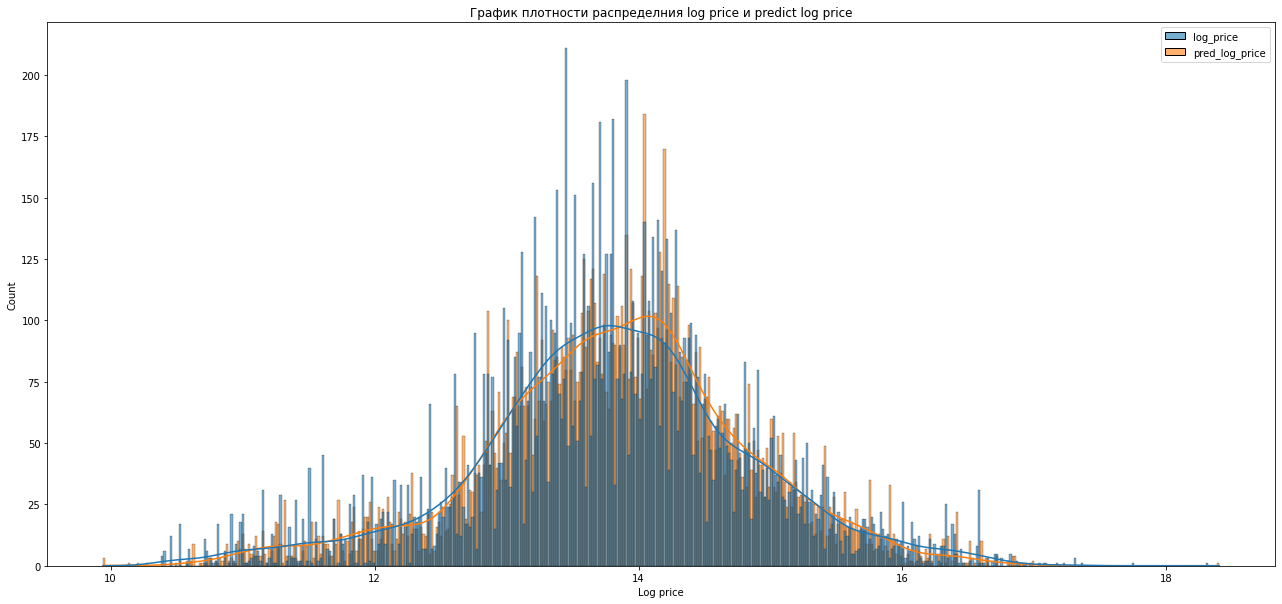

In [274]:
plt.figure(figsize=(22, 10));
sns.histplot([plot_test['log_price'], plot_test['pred_log_price']], color=['g', 'r'], bins=500, alpha=0.6, kde=True)
plt.title('График плотности распределния log price и predict log price')
plt.xlabel('Log price');

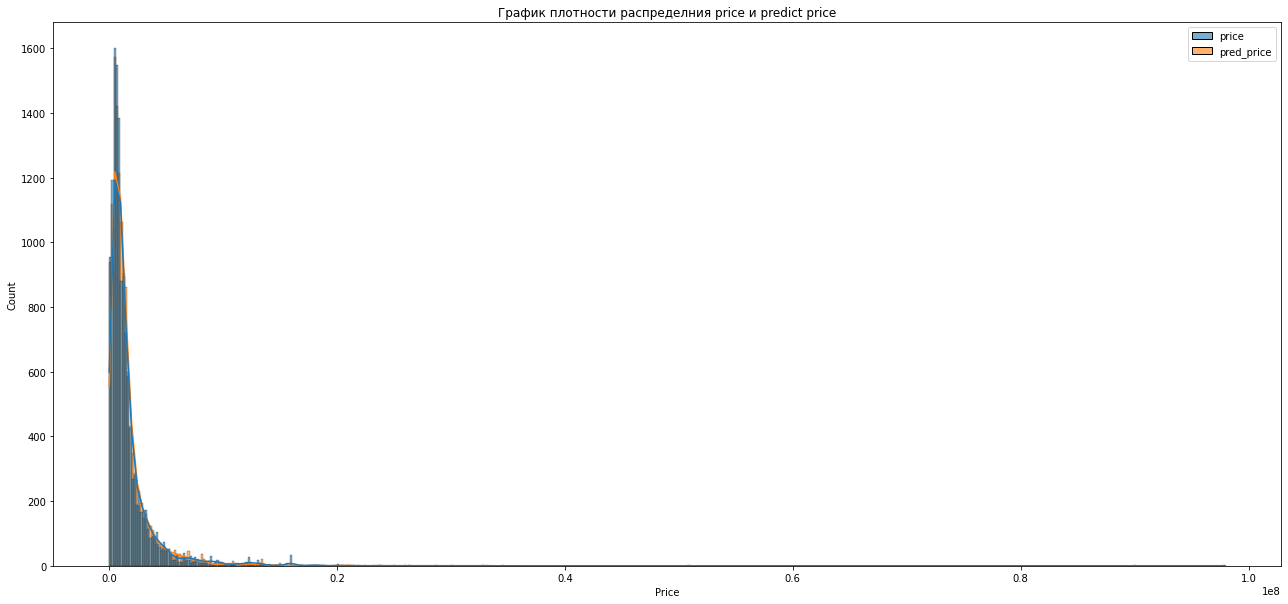

In [275]:
plt.figure(figsize=(22, 10));
sns.histplot([plot_test['price'], plot_test['pred_price']], color=['g', 'r'], bins=500, alpha=0.6, kde=True)
plt.title('График плотности распределния price и predict price')
plt.xlabel('Price');

**Построим еще график зависимости таргета от предсказанного таргета**

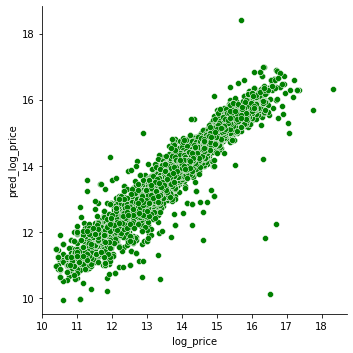

In [277]:
sns.relplot(data=plot_test, x='log_price',\
            y='pred_log_price', color='g', height=5, aspect=1)

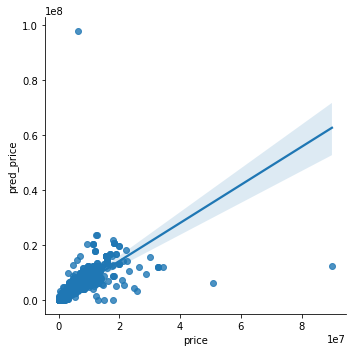

In [278]:
sns.lmplot(data=plot_test, x='price',\
            y='pred_price', height=5, aspect=1)

# **Вывод по модели:**
**Модель неплохо справляется с предсказанием цены на автомобили в низком ценовом сегменте, для дорогих авто наглядно видна существенная ошибка и разброс**

# **Попробуем улучшить результат, разделдив модель на 2**

**1) Если цена до 3 млн.**  
**2) Если цена больше 3 млн.**

In [218]:
DATA.head(1)

run  engine_volume  horsepower_log  ...  restyling  log_price    price
0  56500            3.0        5.497168  ...          1  15.219154  4070000

[1 rows x 16 columns]

In [222]:
DATA.shape

(32753, 16)

# **Займемся первой моделью**
Назовем модель "low"

In [248]:
MOD1 = DATA[DATA.price < 3e6]

In [249]:
X1, y1 = MOD1.iloc[:, :-2], MOD1.iloc[:,-2]

In [250]:
X1.shape

(28417, 14)

**Преобразуем категориальные переменные**

In [251]:
ohe = ColumnTransformer([('One Hot', OneHotEncoder(sparse=False), [4, 5, 6, 7, 8, 9, 10, 11, 12])], remainder='passthrough')
oh1 = ohe.fit(X1)
X1_ohe = oh1.transform(X1)

In [252]:
X1_ohe.shape

(28417, 908)

**Разделим на train и test**

In [253]:
M1_X_train, M1_X_test, M1_y_train, M1_y_test = train_test_split(X1_ohe, y1, test_size=0.2, random_state=RANDOM_SEED)

In [254]:
#Отмасштабируем выборку
scaler = StandardScaler()
scaler.fit(M1_X_train)
M1_X_train = scaler.transform(M1_X_train)
scaler.fit(M1_X_test)
M1_X_test = scaler.transform(M1_X_test)

## Обучим LASSO и дропнем зануляемые признаки 

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

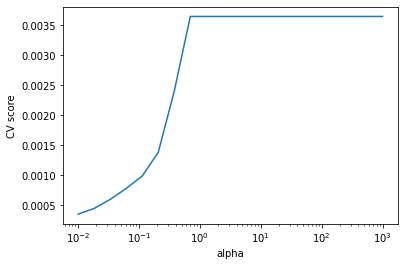

In [236]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_mean_squared_log_error", cv=10)
searcher.fit(M1_X_train, M1_y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [237]:
M1_lasso = Lasso(alpha=0.01).fit(M1_X_train, M1_y_train)

In [255]:
mean_squared_log_error(M1_y_test, M1_lasso.predict(M1_X_test), squared=False)

0.019573626190599137

In [256]:
r2_score(M1_y_test, M1_lasso.predict(M1_X_test))

0.8972227822366318

In [240]:
M1_cf = M1_lasso.coef_

In [241]:
M1_drop = []
for i in range(len(M1_cf)):
  if M1_cf[i] == 0:
    M1_drop.append(i)

**Всего занулено:**

In [257]:
len(M1_drop)

768

**Удалим признаки с нулевыми весами**

In [258]:
M1_X_train = np.delete(M1_X_train, M1_drop, axis=1)
M1_X_test = np.delete(M1_X_test, M1_drop, axis=1)

In [259]:
M1_X_train.shape

(22733, 140)

In [260]:
M1_X_test.shape

(5684, 140)

## **Теперь обучим Ridge регрессию модели low**

Best alpha = 88.5867


Text(0, 0.5, 'CV score')

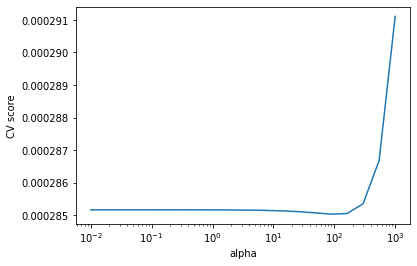

In [261]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_mean_squared_log_error", cv=10)
searcher.fit(M1_X_train, M1_y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [262]:
# Обучим Ridge Регрессию
M1_ridge = Ridge(alpha=88.5867).fit(M1_X_train, M1_y_train)

In [263]:
mean_squared_log_error(M1_y_test, M1_ridge.predict(M1_X_test), squared=False)

0.018202981881402937

In [264]:
r2_score(M1_y_test, M1_ridge.predict(M1_X_test))

0.9115798007936738

**Вывод:**

**Значения метрик получились немного хуже чем для первой модели без разделения по цене**

## Построим графики для визуальной оценки модели "low"

In [265]:
M1_y_pred = M1_ridge.predict(M1_X_test)
M1_y_pred

array([12.79667017, 14.16543877, 13.98663001, ..., 14.32946299,
       14.32325114, 13.23577764])

In [266]:
M1plot_test = M1_y_test.to_frame()
M1plot_test['pred_log_price'] = M1_y_pred
M1plot_test['price'] = np.expm1(M1plot_test['log_price'])
M1plot_test['pred_price'] = np.expm1(M1plot_test['pred_log_price'])
M1plot_test.head(1)

log_price  pred_log_price     price     pred_price
14133   13.01478        12.79667  449000.0  361012.331292

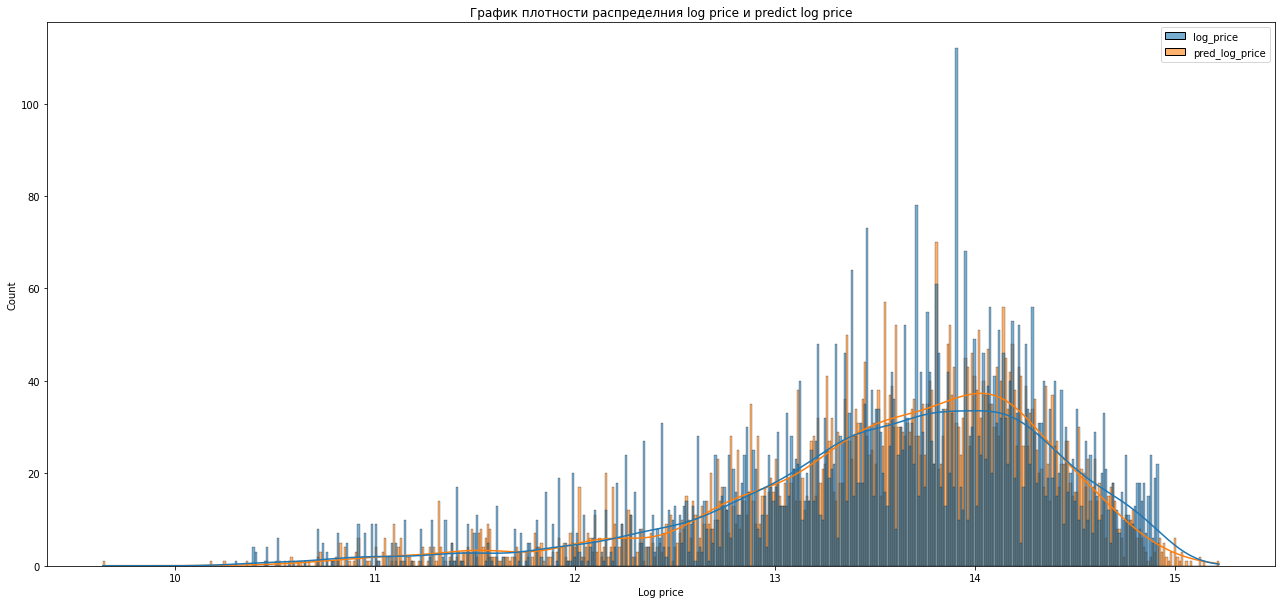

In [272]:
plt.figure(figsize=(22, 10));
sns.histplot([M1plot_test['log_price'], M1plot_test['pred_log_price']], color=['g', 'r'], bins=500, alpha=0.6, kde=True)
plt.title('График плотности распределния log price и predict log price')
plt.xlabel('Log price');

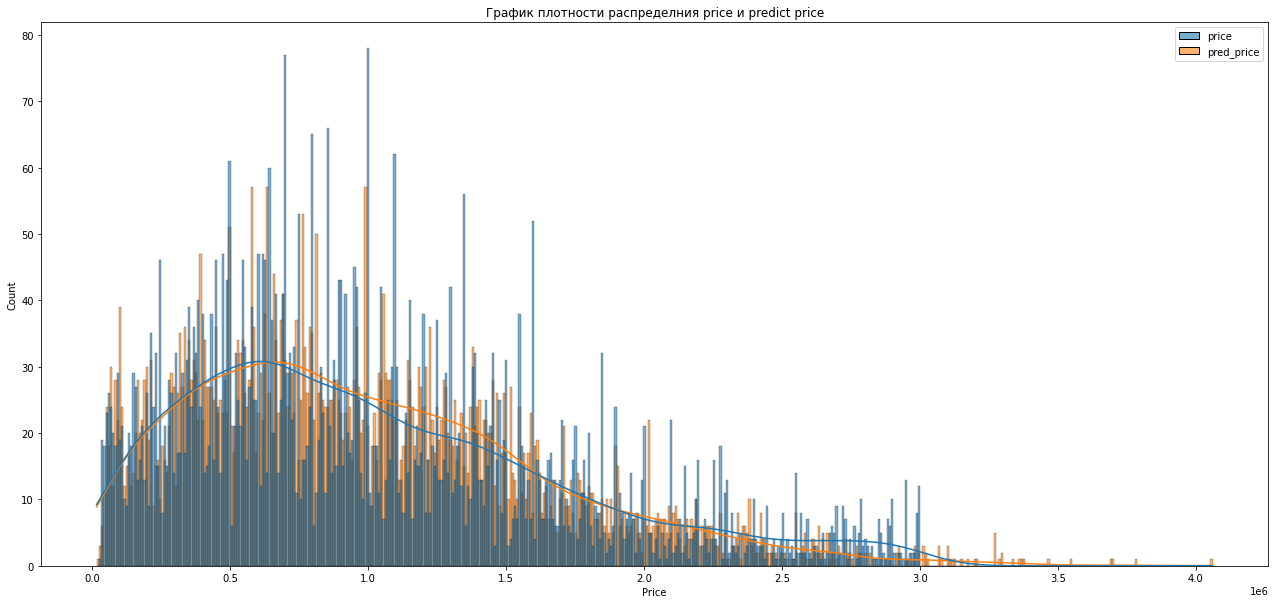

In [273]:
plt.figure(figsize=(22, 10));
sns.histplot([M1plot_test['price'], M1plot_test['pred_price']], color=['g', 'r'], bins=500, alpha=0.6, kde=True)
plt.title('График плотности распределния price и predict price')
plt.xlabel('Price');

**Построим еще график зависимости log price от predict log price**

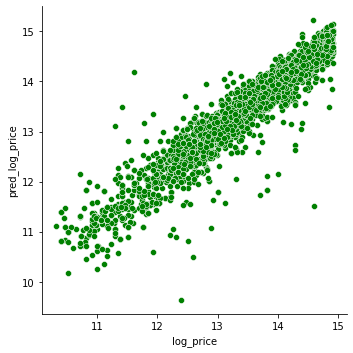

In [279]:
sns.relplot(data=M1plot_test, x='log_price',\
            y='pred_log_price', color='g', height=5, aspect=1)

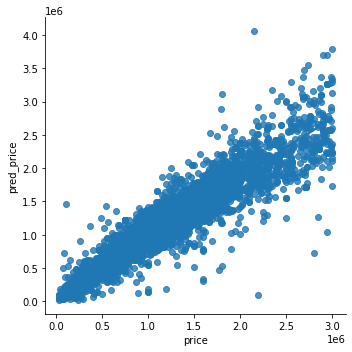

In [280]:
sns.lmplot(data=M1plot_test, x='price',\
            y='pred_price', height=5, aspect=1)

## **Визуально очень неплохой результат**

# **Займемся второй моделью**
Назовем модель "high"

In [281]:
MOD2 = DATA[DATA.price >= 3e6]

In [282]:
X2, y2 = MOD2.iloc[:, :-2], MOD2.iloc[:,-2]

**Преобразуем категориальные переменные**

In [283]:
ohe = ColumnTransformer([('One Hot', OneHotEncoder(sparse=False), [4, 5, 6, 7, 8, 9, 10, 11, 12])], remainder='passthrough')
oh2 = ohe.fit(X2)
X2_ohe = oh2.transform(X2)

In [284]:
X2_ohe.shape

(4336, 311)

**Разделим на train и test**

In [285]:
M2_X_train, M2_X_test, M2_y_train, M2_y_test = train_test_split(X2_ohe, y2, test_size=0.2, random_state=RANDOM_SEED)

In [286]:
#Отмасштабируем выборку
scaler = StandardScaler()
scaler.fit(M2_X_train)
M2_X_train = scaler.transform(M2_X_train)
scaler.fit(M2_X_test)
M2_X_test = scaler.transform(M2_X_test)

## Обучим LASSO и дропнем зануляемые признаки 

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

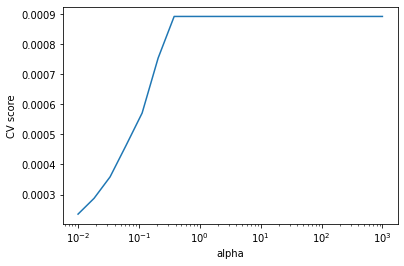

In [287]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_mean_squared_log_error", cv=10)
searcher.fit(M2_X_train, M2_y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [288]:
M2_lasso = Lasso(alpha=0.01).fit(M2_X_train, M2_y_train)

In [289]:
mean_squared_log_error(M2_y_test, M2_lasso.predict(M2_X_test), squared=False)

0.016651689194533654

In [290]:
r2_score(M2_y_test, M2_lasso.predict(M2_X_test))

0.7044577254750792

In [291]:
M2_cf = M2_lasso.coef_

In [292]:
M2_drop = []
for i in range(len(M2_cf)):
  if M2_cf[i] == 0:
    M2_drop.append(i)

**Всего занулено:**

In [293]:
len(M2_drop)

208

**Удалим признаки с нулевыми весами**

In [294]:
M2_X_train = np.delete(M2_X_train, M2_drop, axis=1)
M2_X_test = np.delete(M2_X_test, M2_drop, axis=1)

In [295]:
M2_X_train.shape

(3468, 103)

In [296]:
M2_X_test.shape

(868, 103)

## **Теперь обучим Ridge регрессию модели high**

Best alpha = 162.3777


Text(0, 0.5, 'CV score')

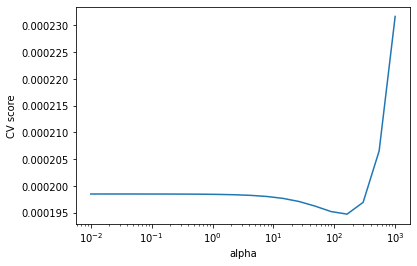

In [297]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_mean_squared_log_error", cv=10)
searcher.fit(M2_X_train, M2_y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [298]:
# Обучим Ridge Регрессию
M2_ridge = Ridge(alpha=162.3777).fit(M2_X_train, M2_y_train)

In [299]:
mean_squared_log_error(M2_y_test, M2_ridge.predict(M2_X_test), squared=False)

0.01602007758585755

In [300]:
r2_score(M2_y_test, M2_ridge.predict(M2_X_test))

0.7287761460129739

**Вывод:**

**Значения метрик получились немного хуже чем для первой модели и модели low потому как выборка дорогих автомобилей небольшая, их всего 4336 и скорее всего в этом ценовом сегменте учитаваются и другие параментры авто (такие как, комплектация салона и тд.)**

## Построим графики для визуальной оценки модели "high"

In [302]:
M2_y_pred = M2_ridge.predict(M2_X_test)

In [303]:
M2plot_test = M2_y_test.to_frame()
M2plot_test['pred_log_price'] = M2_y_pred
M2plot_test['price'] = np.expm1(M2plot_test['log_price'])
M2plot_test['pred_price'] = np.expm1(M2plot_test['pred_log_price'])
M2plot_test.head(1)

log_price  pred_log_price      price    pred_price
28627  14.933599       15.081778  3059000.0  3.547584e+06

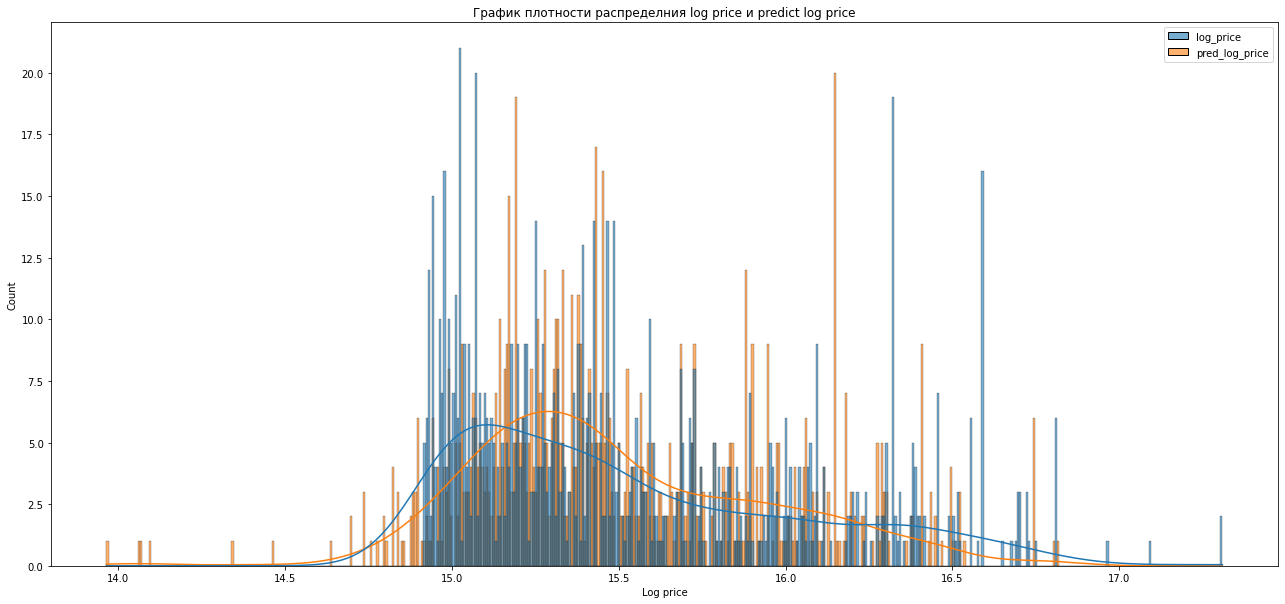

In [304]:
plt.figure(figsize=(22, 10));
sns.histplot([M2plot_test['log_price'], M2plot_test['pred_log_price']], color=['g', 'r'], bins=500, alpha=0.6, kde=True)
plt.title('График плотности распределния log price и predict log price')
plt.xlabel('Log price');

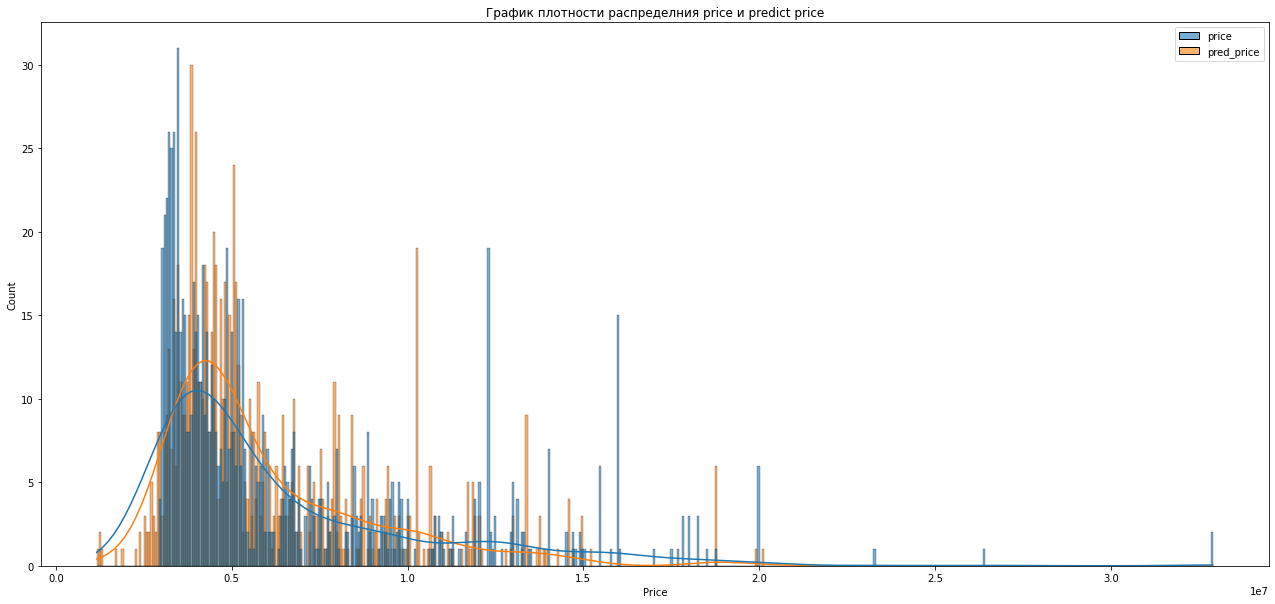

In [305]:
plt.figure(figsize=(22, 10));
sns.histplot([M2plot_test['price'], M2plot_test['pred_price']], color=['g', 'r'], bins=500, alpha=0.6, kde=True)
plt.title('График плотности распределния price и predict price')
plt.xlabel('Price');

**Построим еще график зависимости log price от predict log price**

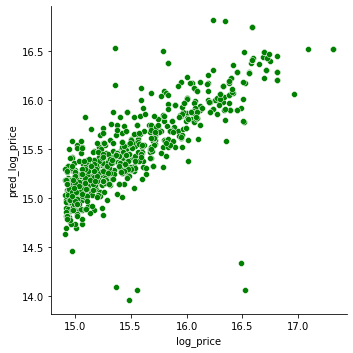

In [306]:
sns.relplot(data=M2plot_test, x='log_price',\
            y='pred_log_price', color='g', height=5, aspect=1)

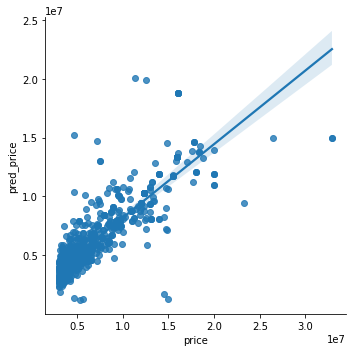

In [307]:
sns.lmplot(data=M2plot_test, x='price',\
            y='pred_price', height=5, aspect=1)

## **Визуально неплохой результат, видно что модель занижает цену**

In [320]:
d = {'RMSLE' : [0.0195, 0.0182, 0.0160], 'R2' : [ 0.9287, 0.9116, 0.7287],}
plot_score = pd.DataFrame(data=d, index=['model1', 'Low', 'High'])
plot_score = plot_score.reset_index()

Text(0.5, 1.0, 'Диаграмма метрик R2 для каждой модели')

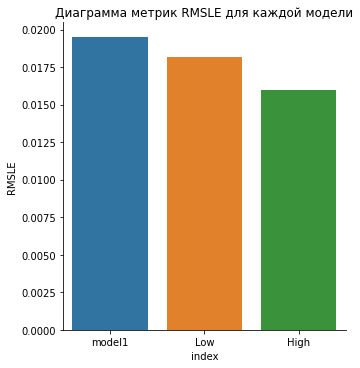

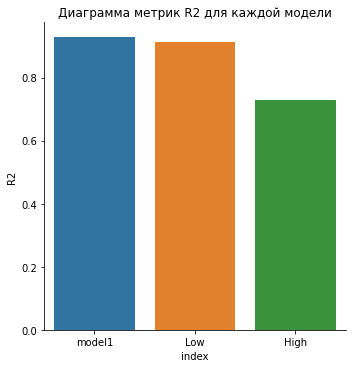

In [339]:
sns.catplot(data=plot_score, x='index', y='RMSLE', kind='bar')
plt.title('Диаграмма метрик RMSLE для каждой модели')
sns.catplot(data=plot_score, x='index', y='R2', kind='bar')
plt.title('Диаграмма метрик R2 для каждой модели')

# **Итоги**

1) Первоначально получилась неплохая модель в которой мы применили L1 и L2 регуляризацию  
(RMSLE = 0.0195; R2 = 0.9287).  
В модели был виден разброс для дорогих авто.

2) С учетом результатов модели 1 было принято решение улучшить результаты и разделить модель на 2.

3) Модель low, которая обучалась на автомобилях дешевле 3 млн. руб. получилась весьма неплохой  
(RMSLE = 0.0182; R2 = 0.9116).

4) Модель high для дорогих авто ввиду меньшего размера выборки получилась хуже,  
(RMSLE = 0.0160; R2 = 0.7287).  
В целом эти две модели друг друга дополнили.